<a href="https://colab.research.google.com/github/AsmaaIbrahiim/Face-Mask-Detection/blob/model_1/Face_Mask_Detection%7C_Transfer_learning_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

University of Science and Technology, Zewail City <br>
Communications and Information Engineering Program <br>
CIE 555 - Deep Learning and Neural Networks <br>
Course Project - **Face Mask Detection**

# **Imports**

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
# =========================================== #
import keras.applications
from keras.models import Model
from keras.layers import Dense, Flatten,Dropout
import tensorflow as tf

# **Dataset Import**

In [2]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1UXAbqllbeh14XslYxAuTOfd3hsvbmp0G'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('archive.zip')

In [3]:
!mkdir /content/dataset
!unzip -q /content/archive.zip -d /content/dataset 

# **Loading data into generators + Helper Functions**

In [4]:
# General Parameters
train_dir='/content/dataset/Face Mask Dataset/Train'
val_dir='/content/dataset/Face Mask Dataset/Validation'
test_dir='/content/dataset/Face Mask Dataset/Test'
HEIGHT = 128
WIDTH = 128
BATCH_SIZE = 500

In [20]:
def get_generators(preprocessing_object = tf.keras.applications.vgg19.preprocess_input):
  #preprocessing_function = preprocessing_object,
  train_generator=ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  val_generator=ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range = 40,
                                    height_shift_range=(-4,4),
                                    width_shift_range = (-4,4),
                                    brightness_range = (0.3,1.7))
  test_generator= ImageDataGenerator(preprocessing_function = preprocessing_object)

  ### Generators; train, val and test
  train_data_generator=train_generator.flow_from_directory(train_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='binary',
                                              color_mode='rgb')

  val_data_generator=val_generator.flow_from_directory(val_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                              class_mode='binary',
                                              color_mode='rgb')
  test_data_generator=test_generator.flow_from_directory(test_dir,
                                              target_size=(HEIGHT,WIDTH),
                                              batch_size = BATCH_SIZE,
                                              shuffle = False,
                                              class_mode='binary',
                                              color_mode='rgb')
  return train_data_generator, val_data_generator, test_data_generator

In [21]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  #plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Cross Entropy')
  #plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [22]:
# Generators
train_data_generator, val_data_generator, test_data_generator = get_generators(tf.keras.applications.vgg19.preprocess_input)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [23]:
images, labels = next(train_data_generator)

print(images.shape)
print(labels.shape)

(500, 128, 128, 3)
(500,)


# **Dataset Visualization**

In [10]:
classes = ['masked','non_masked']

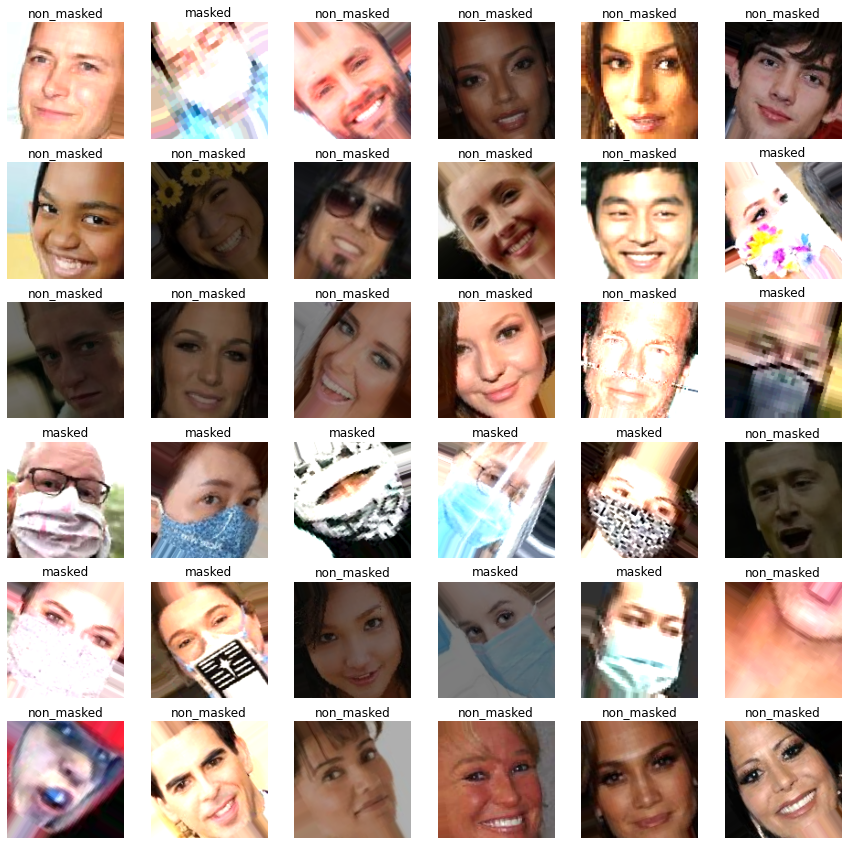

In [27]:
## train
plt.figure(figsize=(15, 15))
for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    images, labels = next(train_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(labels[i])])
    plt.axis("off")

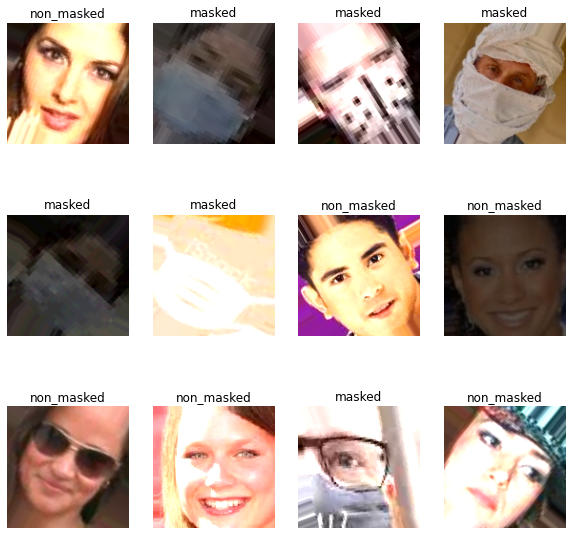

In [28]:
## validation
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    images, labels = next(val_data_generator)
    plt.imshow(images[i])
    plt.title(classes[int(labels[i])])
    plt.axis("off")

# **Models**

*As one of the most popular and effect transfer learning model in use of images, VGG16 model is tried on our dataset.*

## **First Model**: VGG16

The first trial is just using the pre-trained model with minimum contribution

In [25]:
from keras.applications.vgg16 import VGG16

# Load model without classification head
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (HEIGHT, WIDTH, 3))

# Mark loaded layers as not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Print summary
model.summary()

# Compile
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

**Let's train the model!!**

In [26]:
# I can choose small number of epochs for initial investigation for the model perfomance
INITIAL_EPOCHS = 5

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 107s 3s/step - loss: 0.7183 - accuracy: 0.4772 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 2/5
20/20 [==============================] - 51s 3s/step - loss: 0.7025 - accuracy: 0.5076 - val_loss: 0.6912 - val_accuracy: 0.5580
Epoch 3/5
20/20 [==============================] - 51s 3s/step - loss: 0.6918 - accuracy: 0.5405 - val_loss: 0.6784 - val_accuracy: 0.5640
Epoch 4/5
20/20 [==============================] - 51s 3s/step - loss: 0.6799 - accuracy: 0.5683 - val_loss: 0.6619 - val_accuracy: 0.6080
Epoch 5/5
20/20 [==============================] - 51s 3s/step - loss: 0.6676 - accuracy: 0.5918 - val_loss: 0.6622 - val_accuracy: 0.6220


The VGG16 model seems promising but relatively slow, hence we're going to raise the learning rate to notice its effect.

In [30]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 53s 3s/step - loss: 0.6907 - accuracy: 0.5769 - val_loss: 0.5544 - val_accuracy: 0.6880
Epoch 2/5
20/20 [==============================] - 51s 3s/step - loss: 0.5552 - accuracy: 0.6595 - val_loss: 0.4854 - val_accuracy: 0.7260
Epoch 3/5
20/20 [==============================] - 51s 3s/step - loss: 0.4521 - accuracy: 0.7746 - val_loss: 0.3723 - val_accuracy: 0.8460
Epoch 4/5
20/20 [==============================] - 51s 3s/step - loss: 0.3518 - accuracy: 0.8641 - val_loss: 0.3707 - val_accuracy: 0.8040
Epoch 5/5
20/20 [==============================] - 51s 3s/step - loss: 0.3276 - accuracy: 0.8672 - val_loss: 0.3236 - val_accuracy: 0.8700


Yes, that's right! The model behaves better with higher learning rate. Let's try the same model with different optimizer (Adam).

In [31]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = INITIAL_EPOCHS,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/5
20/20 [==============================] - 53s 3s/step - loss: 3.5327 - accuracy: 0.5439 - val_loss: 0.6942 - val_accuracy: 0.4880
Epoch 2/5
20/20 [==============================] - 51s 3s/step - loss: 0.6935 - accuracy: 0.5015 - val_loss: 0.6940 - val_accuracy: 0.4940
Epoch 3/5
20/20 [==============================] - 51s 3s/step - loss: 0.6460 - accuracy: 0.5015 - val_loss: 0.4165 - val_accuracy: 0.9320
Epoch 4/5
20/20 [==============================] - 51s 3s/step - loss: 0.3916 - accuracy: 0.9556 - val_loss: 0.3592 - val_accuracy: 0.9640
Epoch 5/5
20/20 [==============================] - 51s 3s/step - loss: 0.3369 - accuracy: 0.9673 - val_loss: 0.2684 - val_accuracy: 0.9880


Adam Optimizer has already boosted the model behavior. The next step is to include more layers for robustness in addition to dropout layers to somehow avoid overfitting.

In [32]:
# Add new classifier layers
x = Flatten()(base_model.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define new model
model = Model(inputs = base_model.inputs, outputs = output)

# Compile
base_learning_rate = 0.01
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])

history = model.fit(train_data_generator,
                    validation_data = val_data_generator,
                    epochs = 15,
                    steps_per_epoch=10000//BATCH_SIZE,
                    validation_steps=800//BATCH_SIZE,
                    batch_size = BATCH_SIZE)

Epoch 1/15
20/20 [==============================] - 54s 3s/step - loss: 3.7191 - accuracy: 0.5677 - val_loss: 0.2209 - val_accuracy: 0.9180
Epoch 2/15
20/20 [==============================] - 52s 3s/step - loss: 0.2406 - accuracy: 0.9060 - val_loss: 0.1549 - val_accuracy: 0.9440
Epoch 3/15
20/20 [==============================] - 51s 3s/step - loss: 0.1260 - accuracy: 0.9541 - val_loss: 0.1003 - val_accuracy: 0.9540
Epoch 4/15
20/20 [==============================] - 51s 3s/step - loss: 0.0968 - accuracy: 0.9641 - val_loss: 0.0905 - val_accuracy: 0.9700
Epoch 5/15
20/20 [==============================] - 51s 3s/step - loss: 0.0851 - accuracy: 0.9690 - val_loss: 0.0641 - val_accuracy: 0.9720
Epoch 6/15
20/20 [==============================] - 51s 3s/step - loss: 0.0727 - accuracy: 0.9720 - val_loss: 0.0633 - val_accuracy: 0.9860
Epoch 7/15
20/20 [==============================] - 51s 3s/step - loss: 0.0735 - accuracy: 0.9748 - val_loss: 0.0772 - val_accuracy: 0.9760
Epoch 8/15
20/20 [==

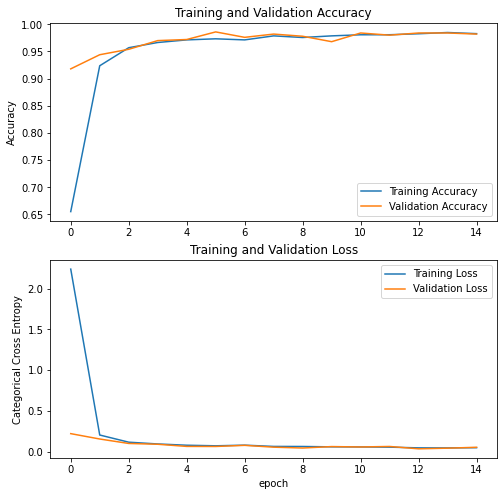

In [33]:
plot_history(history)

In [36]:
# Evaluation on test data !
print(model.metrics_names)
model.evaluate(test_data_generator, batch_size=BATCH_SIZE, steps=20)

['loss', 'accuracy']
20/20 [==============================] - 17s 844ms/step - loss: 1.7855 - accuracy: 0.9778


[1.7855193614959717, 0.9778226017951965]

**Great! We acheived the required performance with VGG16 model**

In [38]:
# Save the model!
model.save('face_mask_detection_vgg16.h5')